## Demographics tables


This notebook loads in the demographic features for all participants after QC has occured. 

It plots the demographics table and the outcome per histology table


In [22]:


# Import packages
import pool.paths as paths
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pool.hdf5_io as hio
import scipy.stats as st



In [23]:
#filenames
demographics_file_name=os.path.join(paths.data_dir,'demographics_qc.csv')

In [24]:
# Load demographics csv file. Preprocessing including QC has already occured
demographics=pd.read_csv(demographics_file_name)

In [25]:
# Calculate no of patients
no_patients = len(demographics['ID'])

# Calculate median age at preop scan & IQR
age_median = np.nanmedian(demographics['Age at preoperative'])
age_iqr = np.nanpercentile(demographics['Age at preoperative'],25),np.nanpercentile(demographics['Age at preoperative'],75)

# Sex
female = np.nansum(demographics['Sex'])
male = np.sum(demographics['Sex']==0)
demographics[np.isnan(demographics['Sex'])]
#check no significant difference in number of males and females using binomial test
sex_p_val = st.binom_test(female,no_patients,0.5)

# Age of onset of epilesy median  & IQR
onset_median= np.nanmedian(demographics['Age of onset'])
onset_iqr = np.nanpercentile(demographics['Age of onset'],25),np.nanpercentile(demographics['Age of onset'],75)

# Duration of epilepsy median & IQR
duration_median = np.nanmedian(demographics['Duration'])
duration_iqr = np.nanpercentile(demographics['Duration'],25),np.nanpercentile(demographics['Duration'],75)

# No of patients who had surgery
surgery = np.nansum(demographics['Surgery'])
no_surgery = no_patients-surgery

# No of patients with histology data available
histo_FCD1 = demographics.groupby('Histology').count().ID['FCD_1']
histo_FCD2A = demographics.groupby('Histology').count().ID['FCD_2A']
histo_FCD2B = demographics.groupby('Histology').count().ID['FCD_2B']
histo_FCD3 = demographics.groupby('Histology').count().ID['FCD_3']
histo_total = histo_FCD1 + histo_FCD2A +histo_FCD2B +histo_FCD3

f_u_median = np.nanmedian(demographics['f/u'])
f_u_iqr = np.nanpercentile(demographics['f/u'],25),np.nanpercentile(demographics['f/u'],75)



In [26]:
#percentage of each histology subtype
d=demographics.groupby('Histology').count()['ID']
q=d/histo_total
q=np.round(100*q)
histology_df =pd.DataFrame(np.vstack([d,q]).T,columns=['Number of patients','Percentage of total patients with histology'],index=['FCD I', 'FCD IIA', 'FCD IIB', 'FCD III'])


In [27]:
# Seizure freedom rates in each histology
s=demographics.groupby('Histology').sum()['Seizure free']
s=list(s)
s.append(np.sum(s))
c=demographics.groupby('Histology').count()['Seizure free']
c=list(c)
c.append(np.sum(c))
m=list(demographics.groupby('Histology').mean()['Seizure free'])
m.append(s[-1]/c[-1])
outcome = pd.DataFrame(np.vstack([s,c,np.round(100*np.array(m))]).T,columns=['Number of patients seizure free','Number of patients with outcome data','Percent seizure free (%)'], index=['FCD I', 'FCD IIA', 'FCD IIB', 'FCD III', 'All histologies'])

In [28]:
#Create data frame
data = {'':  ['Age at preoperative scan (median,IQR)',
             'Sex (f:m)',
             'Age of epilepsy onset (median,IQR)',
             'Duration of epilepsy (median,IQR)',
             'Surgery',
             'Histology',
             'Seizure free','Follow up time'],
        'Patients (n= {})'.format(no_patients): ['{} , ({} - {})'.format(round(age_median,2), np.round(age_iqr,2)[0],np.round(age_iqr,2)[1]),
                                                 '{} : {}'.format(int(female), male),
                                                '{} , ({} - {})'.format(round(onset_median,2), np.round(onset_iqr,2)[0],np.round(onset_iqr,2)[1]),
                                                '{} , ({} - {})'.format(round(duration_median,2), np.round(duration_iqr,2)[0],np.round(duration_iqr,2)[1]),
                                                '{} / {} ({}%)'.format(int(surgery), int(no_surgery+surgery), round(100*(surgery/(no_surgery+surgery)),0)),
                                                '{} / {} ({}%)'.format(int(histo_total),int(no_patients), round(100*(histo_total/no_patients),0)),
                                                '{} / {} ({}%)'.format(int(outcome.iloc[4][1]),int(no_patients), round(100*(outcome.iloc[4][1]/no_patients),0)),
                                                '{} , ({} - {})'.format(round(f_u_median,2),
                                                                       np.round(f_u_iqr,2)[0],
                                                np.round(f_u_iqr,2)[1])],
        }
df = pd.DataFrame (data)
df

,,Patients (n= 580)
0,"Age at preoperative scan (median,IQR)","19.0 , (11.0 - 31.3)"
1,Sex (f:m),281 : 298
2,"Age of epilepsy onset (median,IQR)","6.0 , (2.5 - 12.0)"
3,"Duration of epilepsy (median,IQR)","10.4 , (4.9 - 19.0)"
4,Surgery,423 / 580 (73.0%)
5,Histology,380 / 580 (66.0%)
6,Seizure free,319 / 580 (55.0%)
7,Follow up time,"2.0 , (1.0 - 3.1)"


In [29]:
# Calculate percent of patients age of onset under 10 years
print(np.mean(demographics['Age of onset'].dropna()<10),np.mean(demographics['Duration'].dropna()>10))

0.6785079928952042 0.5098039215686274


In [30]:
outcome

,Number of patients seizure free,Number of patients with outcome data,Percent seizure free (%)
FCD I,24.0,38.0,63.0
FCD IIA,71.0,101.0,70.0
FCD IIB,112.0,162.0,69.0
FCD III,12.0,18.0,67.0
All histologies,219.0,319.0,69.0


In [31]:
import scipy.stats as stats

#Checks that there is no significant difference in outcome according to subtype
df_clean=demographics[['Histology','Seizure free']].dropna()
contingency_table = pd.crosstab(
                df_clean['Histology'],
                df_clean['Seizure free'],
                margins = False
            )
f_obs = np.array(contingency_table)
stat_,p= stats.chi2_contingency(f_obs)[0:2]
contingency_table


Seizure free,0.0,1.0
Histology,,
FCD_1,14,24
FCD_2A,30,71
FCD_2B,50,112
FCD_3,6,12


In [32]:
# No of patients missing lesion masks
no_patients-np.sum(demographics.lesion_masked)

32

In [33]:
# No of patients with lesions lh
print(np.sum(demographics.Hemisphere == 'lh'))
# No of patients with lesions rh
print(np.sum(demographics.Hemisphere == 'rh'))

266
282


In [34]:
# No of lesions in each lobe
demographics.groupby('Lobe').count()['ID']

Lobe
frontal      279
occipital     20
parietal      91
temporal     158
Name: ID, dtype: int64

In [35]:
#Import /define functions for plotting
import matplotlib
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_mosaic(contingency_table, var1, var2,test_to_use,widths,stat_, p):
    """ plot categorical relationships with bar plots"""
    fig = plt.figure(figsize=(10,10))
    font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 60}
    
    matplotlib.rc('font', **font)
    #plt.rcParams["font.family"] = "Times New Roman"
    
    array_table=np.array(contingency_table)
    plots=[]
    running_sums=np.zeros(array_table.shape[1])
    colours=np.array([[176, 146, 59],[137, 96, 179],[86, 174, 108],[186, 73, 91]])/255
    spacing = (np.cumsum(widths)+np.cumsum(np.hstack([0,widths[:-1]])))/2+np.arange(4)/80
    
    for variable in np.arange(array_table.shape[0]):
        mat_col=np.tile(colours[variable],(4,1))
        for k,c in enumerate(mat_col):
            mat_col[k]=lighten_color(c,amount=0.7+(3-k)/8)
        plots+=plt.bar(spacing, array_table[variable,:],
                      bottom=running_sums,color=mat_col,
                       label=contingency_table.index[variable].capitalize(),
                      width = widths,
                      )
        running_sums+=array_table[variable,:]+0.005
    plt.ylabel('Proportion of patients')
    #plt.title('{} - {}'.format(var1,var2))
    names=['I','IIA','IIB','III']
    
    plt.xticks(spacing,names)

    plt.xlabel('Histopathological subtype')
    plt.yticks([0,0.5,1])
    plt.legend(loc=(1.01,.45))#plots)#plots, contingency_table.index,)
    plt.annotate( '{} = {:.1f}\np < {:.3f}'.format(test_to_use.capitalize(),stat_, 0.001),xy=(1.02,.2), xycoords='axes fraction')
    return fig

In [36]:
# Calculate proportion of patients with lesions in each lobe for each histological subtype
df = demographics
var2='Histology'
var1='Lobe'
df_clean=df[[var1,var2]].dropna()
contingency_table = pd.crosstab(
                df_clean[var1],
                df_clean[var2],
                margins = False
            )
stat_,p,dof, exp= stats.chi2_contingency(contingency_table)
widths = np.array(np.sum(contingency_table))/200
contingency_table = contingency_table/np.array(np.sum(contingency_table))

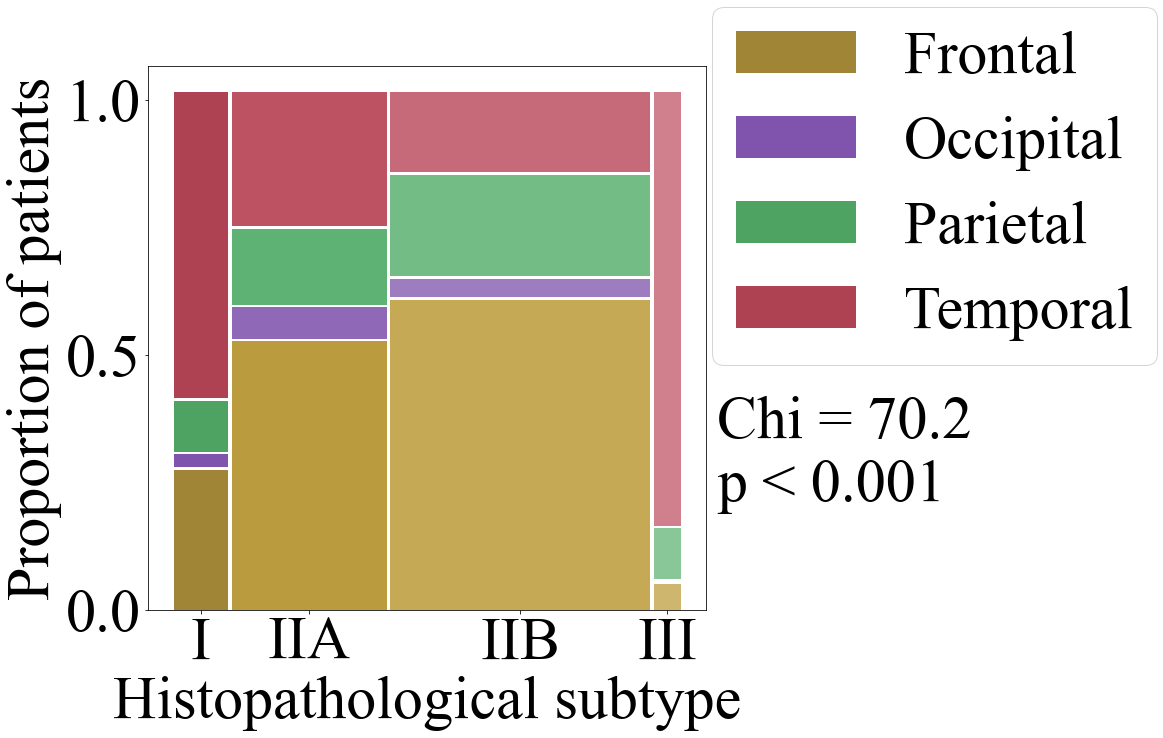

In [37]:
fig=plot_mosaic(contingency_table, var2, var1,'chi',widths,stat_, p)
fig.savefig(os.path.join(paths.fig_dir,'Histology_lobe.pdf'))